In [13]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, ks_2samp # Kolmogorov-Smirnov Test

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score \
                            , precision_recall_fscore_support, log_loss

In [14]:
random_seed = 42

In [15]:
## Fetch data
from ucimlrepo import fetch_ucirepo
# fetch dataset 
uci_data = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = uci_data.data.features 
y = uci_data.data.targets 

In [16]:
le = preprocessing.LabelEncoder()
X = X.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)
y = y.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)


# Drop all columns with NA
X = X.dropna()
y = y.loc[X.index]
# Flatten the y
y = y.values.ravel()


## Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_seed)

In [17]:
## Try Random Forest
random_forest_pipeline = RandomForestClassifier(random_state=random_seed, max_depth=8)
random_forest_pipeline.fit(X_train, y_train)

print("Classification Accuracy:\n", random_forest_pipeline.score(X_test, y_test))

Classification Accuracy:
 0.917981072555205


In [18]:
y_pred = random_forest_pipeline.predict(X_test)
mean_squared_error(y_test, y_pred)

0.722397476340694

In [19]:
class DataAnalyzer():
    """
    # A data analyze tool to analyze data given a model.
    ## Usage:
    Give the model, X data, y data (target data). And choose the task you are performing (Regression, Classification)

    Optional: Provide your own test sets (X_test, y-test), and set test_set=Ture to enable analysis base on test set, or if test_set not provided 
    the function will automatically split the data into train test base on split (default=0.1)

    Different Metrics are also availbale for different tasks

    ```python
    # Example
    dataAnalyzer = DataAnalyzer(random_forest_pipeline, X, y, task="classification", test_set=True, metric="f1")
    ```

    ## Functions:

    ```python
    # This will analyze the influence of each feature by excluding each of them.
    dataAnalyzer.Feature_analyze()

    # This automatically analyze each feature and determine the preprocess that should be done to each feature and return them as a pipeline
    dataAnalyzer.Auto_preprocess()

    # This automatically analyze each feature and determine the preprocess that should be done to each feature and return them as a pipeline
    dataAnalyzer.Auto_preprocess()

    # This compute the data influence for the data with the given method
    dataAnalyzer.CalculateInfluence(method='shapley', num_shuffles=5, threshold=0.98, stat=True)

    # This prints the stat of the influences that are previously computed
    dataAnalyzer.PrintInfluence()

    # After the data influence have been computed, use this function to analyze the negative impact data points
    dataAnalyzer.Analyze_data_influence(negative_threshold_percent=0.1)

    ```

    More help: use .help() function
    """
    def __init__(self, model, X, y, task, X_test=None, y_test=None, test_set=False, split=0.1, metric=None, seed=42):
        self.model = model
        self.X = X
        self.y = y

        assert X.shape[0] == y.shape[0], "Unmatched X, y size"

        self.data_category = "tabular"

        self.test_set = test_set
        self.X_test = X_test
        self.y_test = y_test

        self.data_influences = np.zeros(len(X))
        self.feature_influences = None
        self.influence_method = None

        self.supported_tasks = ["regression", "classification", "probabilities"]
        self.task = task
        if task not in self.supported_tasks:
            print("Supported tasks:", self.supported_tasks)
            raise KeyError("Unsupported Task")
        
        if test_set and (X_test is None or y_test is None):
            print(f"No test set provided, auto splitting dataset with test set of {split*100:.2f}% of the data.")
            self.X, self.X_test, self.y, self.y_test = train_test_split(X, y, test_size=split, random_state=seed)
        elif test_set:
            assert self.X_test.shape[0] == self.y_test.shape[0], "Unmatched X test and y test size"
        
        self.supported_metrics = [["MSE", "MAE", "r2"],["accuracy", "precision", "recall", "f1"], ["log_loss"]]
        self.metric = None

        if metric:
            if metric not in self.supported_metrics[self.supported_tasks.index(task)]:
                print(f"Supported metrics for {task}:", self.supported_metrics[self.supported_tasks.index(task)])
                raise KeyError("Unsupported Metric for this task")
            else:
                self.metric = metric
        else:
            # Default chose the first metric
            self.metric = self.supported_metrics[self.supported_tasks.index(task)][0]

        self.preprocess_pipeline = None

        
        self.base_score = self.calculate_score_base_on_metric(self.X, self.y, self.model)
        

        print(f"Train Data size, X: {self.X.shape}, y: {self.y.shape}")
        if test_set:
            print(f"Test Data size, X: {self.X_test.shape}, y: {self.y_test.shape}")

        print(f"Task: {self.task}, using metric: {self.metric}")
        print(f"Base score: {self.base_score}")
    
    def help(self):
        print("This calculate Influence for data")
        print("Provide data as X and target as y")
        print(f"Supported tasks: {self.supported_tasks}")
        print(f"Supported metrics: {self.supported_metrics}")
        print("Supported influence methods: LOO, shapley")
        print("Supported influence metrics: ")

    def Feature_analyze(self, stat=True):
        """
        This extracts each feature column to analyze the influence of each column.
        """
        print("Analyzing each features")

        X = self.X
        y = self.y
        n_features = X.shape[1]
        if n_features <= 1:
            print("Data only has one feature.")
            return
        # Calculate the base accuracy with all features
        model = self.model

        self.feature_influences = np.zeros(n_features)

        for i in tqdm(range(n_features)):
            X_droped = self.X.drop(self.X.columns[i], axis=1)
            if self.test_set:
                X_test_droped = self.X_test.drop(self.X.columns[i], axis=1)
                current_score = self.calculate_score_base_on_metric(X_droped, y, model, X_test=X_test_droped)
            else:
                current_score = self.calculate_score_base_on_metric(X_droped, y, model)
            influence = self.calculate_influence_base_on_metric(self.base_score, current_score)
            self.feature_influences[i] = influence

        if stat:
            for i in range(n_features):
                print(f"Column: {X.columns[i]}, influence: {self.feature_influences[i]:.4f}")

            min_feature = self.X.iloc[:, [self.feature_influences.argmin()]]

            if self.feature_influences.min() >= 0:
                print("All features have positive impact")
                return

            print(f"The feature has the worst influence: {X.columns[self.feature_influences.argmin()]}, with {self.metric} impact: {self.feature_influences.min()*100:.2f}%")
            print("Skewness of the feature:", skew(min_feature))

            sns.histplot(min_feature, kde=True)  # The `kde` parameter adds a Kernel Density Estimate plot over the histogram.
            plt.title('Distribution')
            plt.xlabel(X.columns[self.feature_influences.argmin()])
            plt.ylabel('Frequency')
            plt.show()
            
            

    def PrintInfluence(self):
        """
        This function prints out the stats for computed data influences
        """
        if self.influence_method:
            print("The data last used:", self.influence_method)
            print(self.data_influences)
            print("Average influence:", self.data_influences.mean())
            if self.data_influences.min() >= 0:
                print("All data have positive influence!")
            else:
                print("Most negative influence:", self.data_influences.min(), ", index:", self.data_influences.argmin())
                print("The data with min influence:")
                print(self.X.iloc[self.data_influences.argmin()])
            print("Most positive influence:", self.data_influences.max(), ", index:", self.data_influences.argmax())
            print("The data with max influence:")
            print(self.X.iloc[self.data_influences.argmax()])
        else:
            print("No analysis has been done")

    def CalculateInfluence(self, method='LOO', n_random_row=10, num_shuffles=10, threshold=0.97, seed=1, stat=True):
        """
        This function calculate the data influence base on selected methods (LOO, shapley).
        """
        n_random_row = len(self.X) if n_random_row > len(self.X) or n_random_row < 0 else n_random_row
        if method == 'LOO':
            self.LOOinfluence(n_random_row=n_random_row, seed=seed, stat=stat)
        elif method == 'shapley':
            self.shapley_influence(num_shuffles=num_shuffles, threshold=threshold, seed=seed, stat=stat)
        else:
            print("Invalid method")

    def LOOinfluence(self, n_random_row, seed=42, stat=True):
        # Clear influences
        self.data_influences = np.zeros(len(self.X))
        X = self.X
        y = self.y
        model = self.model

        print("Calculating data influence using Leave One Out")
        # To select 10 random row indexs for LOO
        np.random.seed(seed)

        selected_indices = np.random.choice(len(self.X), n_random_row, replace=False)

        influences = {}

        # Exclue each random row to compute the LOO prediction
        for loo_ix in tqdm(selected_indices):
            # split data
            X_train_loo = X.drop(X.index[loo_ix])
            y_train_loo = np.delete(y, loo_ix)
            # calculate the influence
            current_score = self.calculate_score_base_on_metric(X_train_loo, y_train_loo, model)
            influence = self.calculate_influence_base_on_metric(self.base_score, current_score)

            influences[loo_ix] = influence
            self.data_influences[loo_ix] = influence

        self.influence_method = 'LOO'
        if stat:
            self.PrintInfluence()

        return influences

    def shapley_influence(self, num_shuffles=10, threshold=0.97, seed=42, stat=True):
        """
        TMC based shapley inflence calculation
        """
        # Clear influences
        self.data_influences = np.zeros(len(self.X))

        print("Calculating data influence using Shapley Value")
        X = self.X
        y = self.y
        model = self.model
        np.random.seed(seed)

        N = X.shape[0]
        full_performance = self.base_score

        shapley_values = np.zeros(N)
        for j in tqdm(range(num_shuffles)):
            permutation = np.random.permutation(N)
            X_perm = X.iloc[permutation]
            y_perm = y[permutation]

            prev_performance = 0
            for i in tqdm(range(N)):
                # model.fit(X_perm[:i+1], y_perm[:i+1])
                performance = self.calculate_score_base_on_metric(X_perm[:i+1], y_perm[:i+1], model)
                # performance = accuracy_score(y, model.predict(X))
                marginal_contribution = performance - prev_performance
                shapley_values[permutation[i]] += marginal_contribution
                prev_performance = performance

                if performance >= threshold * full_performance:
                    break

        self.data_influences = shapley_values / num_shuffles
        self.influence_method = 'shapley'
        if stat:
            self.PrintInfluence()

        return self.data_influences
    
    def Analyze_data_influence(self, plot=True, negative_threshold=0.15):
        """
        This function analyze the computed data influence, negative_threshold_percent 
        is the portion of the negative data we can tolerate compare to the whole data
        """
        if not self.influence_method:
            print("No data influence computation has been done, returning.")
            return

        data_influences = self.data_influences
        X = self.X
        y = self.y


        negative_size = (data_influences < 0).sum()

        print(f"Percentage of negative influence data points in data: {negative_size/X.shape[0] *100 :.2f}%")

        if negative_size < negative_threshold*X.shape[0]:
            print("Negative influence data portion below threshold, returning.")
            return

        negative_data_points = X[data_influences < 0]
        negative_targets = y[data_influences < 0]

        features = X.columns
        n_features = len(features)

        if plot:
            n_cols = int(n_features**0.5)
            n_rows = (n_features + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))  # Adjust size as needed
            fig.suptitle('Feature Distributions for Overall and Negative Data Points')

            # Flatten the axes array if necessary (for easy indexing)

            if n_rows > 1:
                axes = axes.flatten()
            else:
                axes = [axes]

            # Loop through the features and plot histograms
            for idx, feature in enumerate(features):
                # Select the current axis
                ax = axes[idx]
                # Histogram for the overall dataset
                ax.hist(X[feature].dropna(), bins=20, alpha=0.5, label='Overall', color='blue')  # Ensure to drop NA values
                # Histogram for the negative data points
                ax.hist(negative_data_points[feature].dropna(), bins=20, alpha=0.5, label='Negative', color='red')
                ax.set_title(feature)
                ax.set_xlabel(feature)
                ax.set_ylabel('Frequency')
                ax.legend()

            # Hide any unused axes if the number of features is odd
            if n_features % n_cols != 0:
                for ax in axes[n_features:]:
                    ax.axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rectangle in which to fit the subplots
            plt.show()

        print("Testing distribution difference for each feature between negative data points and original dataset.")
        for feature in features:
            # Perform Anderson-Darling test to test if the distribution of that feature is aligned 
            ks_stat, ks_pvalue = ks_2samp(X[feature].dropna(), negative_data_points[feature].dropna(), method='exact')

            print(f"Feature in negative data points: {feature}, KS Statistic: {ks_stat}, P-value: {ks_pvalue}")

            if ks_pvalue < 0.1:
                unbalanced_feature = negative_data_points[feature]
                print(f"Feature {feature} distributions is statistically different.")
                print(f"Consider examine data with feature {feature} with range {unbalanced_feature.mean() - unbalanced_feature.std():.3f} to {unbalanced_feature.mean() + unbalanced_feature.std():.3f}")

                plt.subplot(1, 2, 1)
                plt.hist(X[feature], bins=20, alpha=0.5, label='Overall', color='blue')
                plt.hist(negative_data_points[feature], bins=20, alpha=0.5, label='Negative', color='red')
                plt.title(f'{feature} Distribution')
                plt.xlabel(feature)
                plt.ylabel('Frequency')
                plt.legend()
    
    def Auto_preprocess(self):
        """
        This auto analyze data points and feature to suggestion an optimal pipeline for dataprocessing
        """
        X = self.X
        y = self.y
        model = self.model
        
        if not self.feature_influences:
            self.Feature_analyze(stat=False)

        negative_columns = X.columns[self.feature_influences < 0]

        if len(negative_columns) == 0:
            print("Looking good! All features have positive impact.")
            return

        negative_features = X[negative_columns]
        
        numeric_features = negative_features.select_dtypes(include=['int', 'float']).columns

        categorical_features = negative_features.select_dtypes(include=['object', 'category']).columns
        preprocessing_steps = []

        current_base_score = self.base_score

        # Numeric Feature Preprocessing
        for feature in numeric_features:
            current_steps = preprocessing_steps
            if X[feature].isnull().mean() > 0.1:  # Arbitrary threshold for missing data
                preprocessing_steps.append((f'imputer_{feature}', SimpleImputer(strategy='median'), [feature]))
                current_base_score = self.try_adding_preprocess(preprocessing_steps, current_base_score, column=feature, method='imputer')
                
            if X[feature].skew() > 1 or X[feature].skew() < -1:  # Check skewness
                preprocessing_steps.append((f'scaler_{feature}', PowerTransformer(method='yeo-johnson'), [feature]))
                current_base_score = self.try_adding_preprocess(preprocessing_steps, current_base_score, column=feature, method='scaler')

            # None of the method works try removing
            if current_steps == preprocessing_steps:
                print(f"None of the preprocess works for this column: {feature}. Please examine it")
                

        # Categorical Feature Preprocessing
        for feature in categorical_features:
            current_steps = preprocessing_steps
            if X[feature].nunique() > 10:  # Arbitrary cutoff for too many categories
                preprocessing_steps.append((f'encoder_{feature}', OneHotEncoder(handle_unknown='ignore'), [feature]))
                current_base_score = self.try_adding_preprocess(preprocessing_steps, current_base_score, column=feature, method='encoder')

            if X[feature].isnull().mean() > 0.1:
                preprocessing_steps.append((f'imputer_{feature}', SimpleImputer(strategy='constant', fill_value='missing'), [feature]))
                current_base_score = self.try_adding_preprocess(preprocessing_steps, current_base_score, column=feature, method='imputer')

            # None of the method works try removing
            if current_steps == preprocessing_steps:
                print(f"None of the preprocess works for this column: {feature}. Please examine it")

        # Create the column transformer and pipeline
        preprocessor = ColumnTransformer(transformers=preprocessing_steps, remainder='passthrough')
        full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', clone(model))])

        # Fit the pipeline
        # full_pipeline.fit(X, y)

        # y_pred = full_pipeline.predict(X)
        current_score = self.calculate_score_base_on_metric(X, y, full_pipeline)

        preprocess_influence = -self.calculate_influence_base_on_metric(self.base_score, current_score)

        print(f"Preprocess pipeline: {preprocessing_steps}")
        print(f"New score {current_score}, with improvement {preprocess_influence}")

        self.preprocess_pipeline = full_pipeline

        return full_pipeline

    def try_adding_preprocess(self, preprocessing_steps, current_base_score, column, method):
        print(f"Trying {method} on column: {column}")
        preprocessor = ColumnTransformer(transformers=preprocessing_steps, remainder='passthrough')
        temp_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', clone(self.model))])
        # Fit the pipeline
        # temp_pipeline.fit(self.X, self.y)
        # y_pred = temp_pipeline.predict(self.X)
        current_score = self.calculate_score_base_on_metric(self.X, self.y, temp_pipeline)
        preprocess_influence = -self.calculate_influence_base_on_metric(current_base_score, current_score)
        print(f"This preprocess has influence: {preprocess_influence}")
        if preprocess_influence > 0:
            print("Performance Improved, saved this preprocess")
            return current_score
        else:
            print("Preprocess dones't work")
            preprocessing_steps.pop()
            return current_base_score
        
    def calculate_score_base_on_metric(self, X, y, model, X_test=None, y_test=None):
        model.fit(X, y)
        X_test = X_test if X_test is not None else self.X_test
        y_test = y_test if y_test is not None else self.y_test
        if self.test_set:
            y_pred = model.predict(X_test)
            y_true = y_test
        else:
            y_pred = model.predict(X)
            y_true = y
        metric = self.metric
        supported = [["MSE", "MAE", "r2"],["accuracy", "precision", "recall", "f1"], ["log_loss"]]
        if metric == "MSE":
            return mean_squared_error(y_true, y_pred)
        elif metric == "MAE":
            return mean_absolute_error(y_true, y_pred)
        elif metric == "r2":
            return r2_score(y_true, y_pred)
        elif metric == "accuracy":
            return accuracy_score(y_true, y_pred)
        elif metric == "precision":
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            return precision
        elif metric == "recall":
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            return recall
        elif metric == "f1":
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            return f1
        elif metric == "log_loss":
            return log_loss(y_true, y_pred)
        else:
            raise KeyError("Unsupported Metric")
    
    def calculate_influence_base_on_metric(self, base_score, current_score):
        # Errors: lower better
        metric = self.metric
        if metric in ["MSE", "MAE", "log_loss"]:
            influence = current_score - base_score
        # Accuracy: higher better
        elif metric in ["accuracy", "precision", "recall", "f1", "r2"]:
            influence = base_score - current_score
        else:
            raise KeyError("Unsupported Metric")
        return influence

In [20]:
random_forest_pipeline = RandomForestClassifier(random_state=random_seed, max_depth=6)
random_forest_pipeline.fit(X_train, y_train)

print("Classification Accuracy:\n", random_forest_pipeline.score(X_test, y_test))

Classification Accuracy:
 0.9085173501577287


In [21]:
influenceA = DataAnalyzer(random_forest_pipeline, X, y, task="classification", test_set=True, metric="accuracy", split=0.15)
# influenceA = DataAnalyzer(random_forest_pipeline, X_train, y_train, task="classification", X_test=X_test, y_test=y_test, test_set=True, metric="accuracy", split=0.15)

influenceA.Auto_preprocess()

No test set provided, auto splitting dataset with test set of 15.00% of the data.
Train Data size, X: (1794, 16), y: (1794,)
Test Data size, X: (317, 16), y: (317,)
Task: classification, using metric: accuracy
Base score: 0.9085173501577287
Analyzing each features


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]

Looking good! All features have positive impact.


In [22]:
influenceA.CalculateInfluence(method='LOO', num_shuffles=5, threshold=0.98, stat=True)

Calculating data influence using Leave One Out


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]

The data last used: LOO
[0.         0.         0.         ... 0.00315457 0.         0.        ]
Average influence: 6.857769853243731e-05
All data have positive influence!
Most positive influence: 0.03154574132492116 , index: 1401
The data with max influence:
Gender                             1.00
Age                               18.00
Height                             1.72
Weight                            53.00
family_history_with_overweight     1.00
FAVC                               1.00
FCVC                               2.00
NCP                                3.00
CAEC                               2.00
SMOKE                              0.00
CH2O                               2.00
SCC                                0.00
FAF                                0.00
TUE                                2.00
CALC                               2.00
MTRANS                             3.00
Name: 496, dtype: float64


In [23]:
influenceA.CalculateInfluence(method='shapley', num_shuffles=2, threshold=0.98, stat=True)

Calculating data influence using Shapley Value


100%|██████████| 2/2 [03:33<00:00, 106.82s/it]

The data last used: shapley
[ 0.00315457  0.          0.         ...  0.05362776  0.
 -0.00157729]
Average influence: 0.0004976279149917882
Most negative influence: -0.042586750788643546 , index: 1518
The data with min influence:
Gender                              0.000000
Age                                21.008297
Height                              1.723587
Weight                            131.929712
family_history_with_overweight      1.000000
FAVC                                1.000000
FCVC                                3.000000
NCP                                 3.000000
CAEC                                2.000000
SMOKE                               0.000000
CH2O                                1.683448
SCC                                 0.000000
FAF                                 1.645532
TUE                                 0.858059
CALC                                2.000000
MTRANS                              3.000000
Name: 2054, dtype: float64
Most positive influence

In [24]:
influenceA.PrintInfluence()

The data last used: shapley
[ 0.00315457  0.          0.         ...  0.05362776  0.
 -0.00157729]
Average influence: 0.0004976279149917882
Most negative influence: -0.042586750788643546 , index: 1518
The data with min influence:
Gender                              0.000000
Age                                21.008297
Height                              1.723587
Weight                            131.929712
family_history_with_overweight      1.000000
FAVC                                1.000000
FCVC                                3.000000
NCP                                 3.000000
CAEC                                2.000000
SMOKE                               0.000000
CH2O                                1.683448
SCC                                 0.000000
FAF                                 1.645532
TUE                                 0.858059
CALC                                2.000000
MTRANS                              3.000000
Name: 2054, dtype: float64
Most positive influence

Percentage of negative influence data points in data: 33.00%


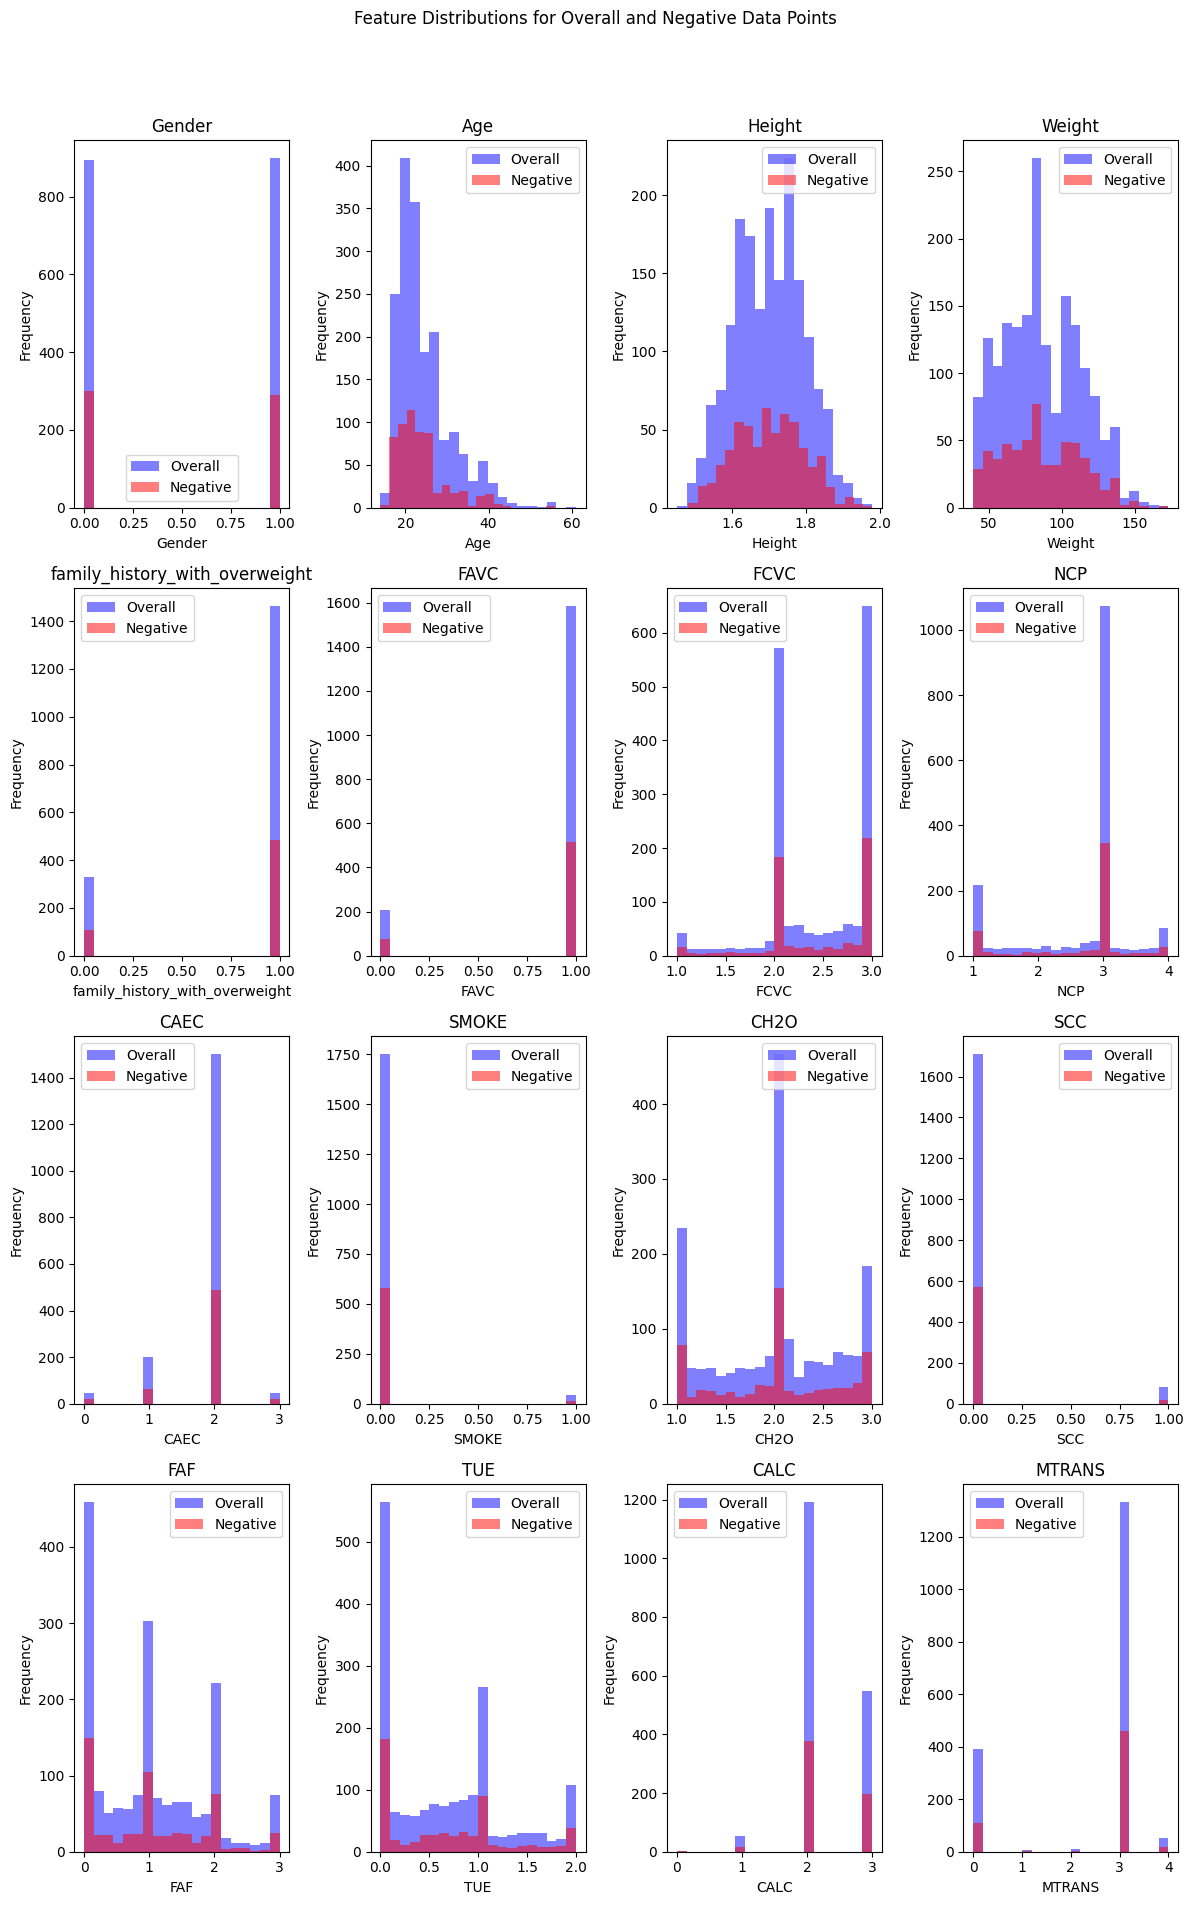

Testing distribution difference for each feature between negative data points and original dataset.
Feature in negative data points: Gender, KS Statistic: 0.01011818674862153, P-value: 0.9999999998266221
Feature in negative data points: Age, KS Statistic: 0.037497363584320105, P-value: 0.5430672704872926
Feature in negative data points: Height, KS Statistic: 0.017739311217572086, P-value: 0.998505891401257
Feature in negative data points: Weight, KS Statistic: 0.023087468739642653, P-value: 0.9661185991555032
Feature in negative data points: family_history_with_overweight, KS Statistic: 0.003203245051071138, P-value: 1.0
Feature in negative data points: FAVC, KS Statistic: 0.014125538582060322, P-value: 0.9999827797859376
Feature in negative data points: FCVC, KS Statistic: 0.016571755702190483, P-value: 0.9995147384064447
Feature in negative data points: NCP, KS Statistic: 0.017741194371629153, P-value: 0.9985033108005149
Feature in negative data points: CAEC, KS Statistic: 0.00756839

In [25]:
influenceA.Analyze_data_influence()